<a href="https://colab.research.google.com/github/SujayVivek/MLSP-Lab-8th-Sem-2026/blob/main/exp1cSPML2-fingerprint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 # Used for image reading
from google.colab import files # Useful if you are using Google Colab

In [4]:
# Upload the file if in Colab, or ensure 'fingerprint.tif' is in your directory
# uploaded = files.upload()

img = cv2.imread('fingerprint.tif', cv2.IMREAD_UNCHANGED)

# Determine bit depth for correct normalization
if img.dtype == np.uint16:
    max_intensity = 65535
else:
    max_intensity = 255

# Normalize image to range [0, 1] (Standardization concept)
img_norm = img.astype(float) / max_intensity

# Handle color channels
if len(img_norm.shape) == 3:
    rows, cols, channels = img_norm.shape
else:
    rows, cols = img_norm.shape
    channels = 1

In [5]:
# Adjust sigma to match the [0, 1] scale
sigma_original = 25
sigma = sigma_original / max_intensity
mu = 0

# Generate Uniform random variables
U1 = np.random.rand(rows, cols) if channels == 1 else np.random.rand(rows, cols, channels)
U2 = np.random.rand(rows, cols) if channels == 1 else np.random.rand(rows, cols, channels)

# Box-Muller Transform for Gaussian Noise
noise = sigma * np.sqrt(-2.0 * np.log(U1)) * np.cos(2.0 * np.pi * U2) + mu
noisy_img_norm = img_norm + noise

# Clip values to stay within [0, 1]
noisy_img_norm = np.clip(noisy_img_norm, 0, 1)

# SVD Preparation: Convert to grayscale if RGB
if channels == 3:
    g = cv2.cvtColor(noisy_img_norm.astype(np.float32), cv2.COLOR_BGR2GRAY)
    ref_img = cv2.cvtColor(img_norm.astype(np.float32), cv2.COLOR_BGR2GRAY)
else:
    g = noisy_img_norm
    ref_img = img_norm

In [6]:
# Find V using the covariance method (G' * G)
G_mat = np.dot(g.T, g)
eigvals, V = np.linalg.eigh(G_mat)

# Sort eigenvalues and eigenvectors descending
idx = np.argsort(eigvals)[::-1]
eigvals_sorted = eigvals[idx]
V = V[:, idx]

# Singular values are the square roots of eigenvalues
singular_values = np.sqrt(np.maximum(eigvals_sorted, 0))

# Set k_target (Rank reduction)
k_target = min(50, rows, cols)

# Calculate U (Projection)
U = np.zeros((rows, k_target))
for i in range(k_target):
    if singular_values[i] > 1e-10:
        # U = g * V * inv(S)
        U[:, i] = np.dot(g, V[:, i]) / singular_values[i]

# Reconstruction
S_diag = np.diag(singular_values[:k_target])
reconstructed_g = np.dot(U, np.dot(S_diag, V[:, :k_target].T))

# Clip reconstruction to valid range [0, 1]
reconstructed_g = np.clip(reconstructed_g, 0, 1)

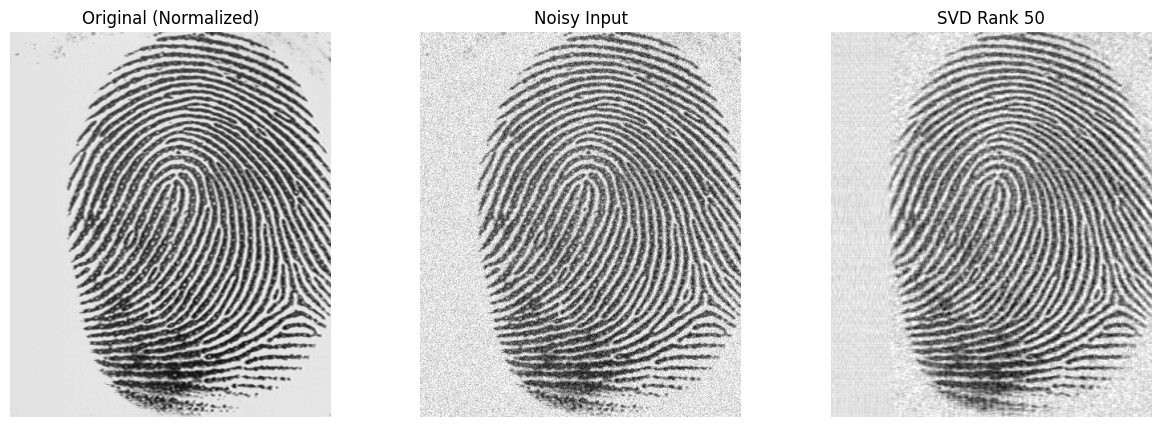

--- Reconstruction Quality ---
Normalization: [0, 1] scale
Rank used:     50
MSE:           0.004865
PSNR:          23.13 dB


In [7]:
# MSE calculation [cite: 30, 165]
mse_val = np.mean((ref_img - reconstructed_g)**2)

# PSNR calculation for [0, 1] range
peak_val = 1.0
psnr_val = 10 * np.log10(peak_val**2 / mse_val)

# Visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img_norm, cmap='gray')
plt.title('Original (Normalized)')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(g, cmap='gray')
plt.title('Noisy Input')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(reconstructed_g, cmap='gray')
plt.title(f'SVD Rank {k_target}')
plt.axis('off')

plt.show()

# Display Results
print(f"--- Reconstruction Quality ---")
print(f"Normalization: [0, 1] scale")
print(f"Rank used:     {k_target}")
print(f"MSE:           {mse_val:.6f}")
print(f"PSNR:          {psnr_val:.2f} dB")